In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torchvision
import torch.optim as optim

import numpy as np
from sklearn.manifold import TSNE

import argparse, sys, os

import torch
from torchtext.legacy import data, datasets
# from torchtext import data, datasets
import random
torch.backends.cudnn.deterministic = True

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import time
from collections import Counter
import matplotlib.pyplot as plt 


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Wiki.csv to Wiki.csv


In [12]:
import pandas as pd

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')


twitter = pd.read_csv("twitter.csv")
wiki = pd.read_csv("Wiki.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# remove puctunations, https
import re
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    return df
twitter = clean_text(twitter, 'text')
wiki = clean_text(wiki, 'text')

stopwords = nltk.corpus.stopwords.words('english')
twitter['text'] = twitter['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
wiki['text'] = wiki['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))


In [14]:
twitter['domain'] = 0
wiki['domain'] = 1

In [15]:
twitter = twitter[['text', 'label', 'domain']]
wiki = wiki[['text', 'label', 'domain']]

In [16]:
twitter.to_csv('T.csv', index=False)
wiki.to_csv('W.csv', index=False)

#tokenize

In [17]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [18]:
TEXT = data.Field(tokenize = 'spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)
DOMAIN = data.LabelField(dtype=torch.float)

In [19]:
#loading custom dataset
W =data.TabularDataset(path = 'W.csv',format = 'csv',fields = [('text', TEXT),('label',LABEL),('domain',DOMAIN)],skip_header = True)

#print preprocessed text
print(vars(W.examples[0]))

{'text': ['right', 'fine', 'did', 'nt', 'even', 'start', 'discussion', 'joined', 'every', 'time', 'someone', 'tries', 'get', 'article', 'neutral', 'bullheaded', 'evolutionist', 'jumps', 'throat', 'stupid', 'evolution', 'proven', 'you', 're', 'idiot'], 'label': '1.0', 'domain': '1'}


In [20]:
#loading custom dataset
T =data.TabularDataset(path = 'T.csv',format = 'csv',fields = [('text', TEXT),('label',LABEL),('domain',DOMAIN)],skip_header = True)

#print preprocessed text
print(vars(T.examples[0]))

{'text': ['paid', 'hold', 'monkey', 'look', 'monkey', 'real', 'af'], 'label': '0.0', 'domain': '0'}


# split train, test, val

In [21]:
def split(train_size, dataset):
  train, test = dataset.split([6000, 2000], random_state = random.seed(SEED))
  train, other = train.split([train_size, 6000-train_size], random_state = random.seed(SEED))
  # train, val = train.split(random_state = random.seed(SEED))
  return train, test

train_size = 1000
W_train_data, W_test_data = split(train_size, W)
T_train_data, T_test_data = split(train_size, T)

#convert texts into integer sequences.

build vocabulary

In [22]:
#initialize glove embeddings
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(T_train_data, W_train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_) 
LABEL.build_vocab(T_train_data, W_train_data)
DOMAIN.build_vocab(T_train_data, W_train_data)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399861/400000 [00:15<00:00, 24939.91it/s]

creat iterators

In [23]:
#set batch size
BATCH_SIZE = 64

#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

T_train_iterator, T_test_iterator = data.BucketIterator.splits(
    (T_train_data, T_test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

W_train_iterator, W_test_iterator = data.BucketIterator.splits(
    (W_train_data, W_test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [24]:
class GradReverse(torch.autograd.Function):
    """
    Extension of grad reverse layer
    """
    @staticmethod
    def forward(ctx, x, constant):
        ctx.constant = constant
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg() * ctx.constant
        return grad_output, None

    def grad_reverse(x, constant):
        return GradReverse.apply(x, constant)

class Extractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx, pretrained_embeddings):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes, embedding_dim))
        
        
        
        self.fc = nn.Linear(n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        # self.relu = nn.ReLU(inplace=True)
        # self.max_pool1d = nn.MaxPool1d(2,2)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        x = self.dropout(pooled_0)
        #x = [batch size, n_filters * len(filter_sizes)]
            
        return x

class Class_classifier(nn.Module):

    def __init__(self, n_filters, output_dim):
        super(Class_classifier, self).__init__()
        self.fc = nn.Linear(n_filters, output_dim)

    def forward(self, input):
        x = self.fc(input)
        return x

class Domain_classifier(nn.Module):

    def __init__(self, n_filters, output_dim):
        super(Domain_classifier, self).__init__()
        self.fc = nn.Linear(n_filters, output_dim)

    def forward(self, input, constant):
        input = GradReverse.grad_reverse(input, constant)
        return self.fc(input)




In [25]:
def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer

In [26]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = 1
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
pretrained_embeddings = TEXT.vocab.vectors

extractor = Extractor(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX,pretrained_embeddings )
class_classifier = Class_classifier(N_FILTERS, OUTPUT_DIM)
domain_classifier = Domain_classifier(N_FILTERS, OUTPUT_DIM)

check the number of parameters

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(extractor) + count_parameters(class_classifier) + count_parameters(domain_classifier):,} trainable parameters')

The model has 1,041,603 trainable parameters


zero the initial weights of the unknown and padding tokens







In [28]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

extractor.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
extractor.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [29]:
criterion = nn.BCEWithLogitsLoss()

extractor = extractor.to(device)
class_classifier = class_classifier.to(device)
domain_classifier = domain_classifier.to(device)

criterion = criterion.to(device)

define function to calculate the correct predictions

In [30]:
def train(training_mode, extractor, class_classifier, domain_classifier, criterion,
          source_data, target_data, optimizer, epoch):
  
    epoch_loss = 0
    epoch_acc = 0

    # setup models
    extractor.train()
    class_classifier.train()
    domain_classifier.train()

    # steps
    start_steps = epoch * len(source_data)
    total_steps = 10 * len(source_data)

    for batch_idx,(sdata, tdata) in enumerate(zip(source_data, target_data)):
        if training_mode == 'dann':
            # setup hyperparameters
            p = float(batch_idx + start_steps) / total_steps
            constant = 2. / (1. + np.exp(-gamma * p)) - 1

            # prepare the data
            input1, label1, domain1 = sdata.text, sdata.label, sdata.domain
            input3, label3, domain3 = tdata.text, tdata.label, tdata.domain
    
            # setup optimizer
            optimizer = optimizer_scheduler(optimizer, p)
            optimizer.zero_grad()

            # compute the output of source domain and target domain
            src_feature = extractor(input1)
            tgt_feature = extractor(input3)

            # compute the class loss of src_feature
            class_pred = class_classifier(src_feature).squeeze(1)
            
            class_loss = criterion(class_pred, label1)
  

            # compute the domain loss of src_feature and target_feature
            tgt_preds = domain_classifier(tgt_feature, constant).squeeze(1)
            src_pred = domain_classifier(src_feature, constant).squeeze(1)
            
            tgt_loss = criterion(tgt_preds, domain3)
            src_loss = criterion(src_pred, domain1)
            
            
            domain_loss = tgt_loss + src_loss

            loss = class_loss + theta * domain_loss

            loss.backward()
            optimizer.step()

            # print loss

            if (batch_idx + 1) % 10 == 0:
                print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tClass Loss: {:.6f}\tDomain Loss: {:.6f}'.format(
                    batch_idx * len(input1), len(W_train_data),
                    100. * batch_idx / len(source_data), loss.item(), class_loss.item(),
                    domain_loss.item()
                ))
                
            total_loss.append(loss.item())
            c_loss.append( class_loss.item())
            d_loss.append(domain_loss.item())
   

In [63]:
def visualize(extractor, class_classifier, domain_classifier, source_data, target_data):
 
    # setup the network
    extractor.eval()
    class_classifier.eval()
    domain_classifier.eval()
    code_vector_list = []
    label_list = []
 
    
    for batch_idx, sdata in enumerate(source_data):
        # setup hyperparameters
        p = float(batch_idx) / len(source_data)
        constant = 2. / (1. + np.exp(-10 * p)) - 1.

        input1, label1, domain1 = sdata.text, sdata.label, sdata.domain
        code_vector = extractor(input1).cpu()
        code_label = label1.cpu()
        code_vector_list.append(code_vector)
        label_list.append(code_label)
    return code_vector_list, label_list

In [67]:
src_train_data = T_train_iterator
src_test_data = T_test_iterator
tgt_train_data = W_train_iterator
tgt_test_data = W_test_iterator
code_vector_list, label_list = visualize(extractor, class_classifier, domain_classifier, src_test_data, tgt_test_data)

In [69]:
code_vector_list.cpu().detach().numpy()
label_list.cpu().detach().numpy()

AttributeError: ignored

RuntimeError: ignored

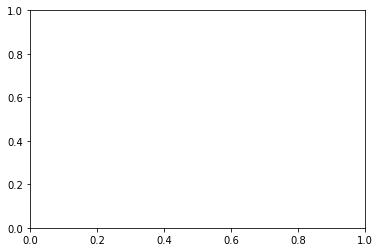

In [68]:
import matplotlib.pyplot as plt
plt.scatter(code_vector_list,label_list )

In [ ]:
code_vector_list

In [58]:
code_vector_list = code_vector_list[:1000]
label_list = label_list

In [42]:
colors = np.array(['r', 'g'])
colors_test = colors[int(label_list)]

fig = plt.figure(figsize=(8, 8))
plt.scatter(code_vector_list[:, 0], code_vector_list[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fname = 'ae_code.pdf'
plt.savefig(fname)

TypeError: ignored

In [31]:
def test(extractor, class_classifier, domain_classifier, source_data, target_data):
 
    # setup the network
    extractor.eval()
    class_classifier.eval()
    domain_classifier.eval()
    source_correct = 0.0
    target_correct = 0.0
    domain_correct = 0.0
    tgt_correct = 0.0
    src_correct = 0.0
    
    for batch_idx, sdata in enumerate(source_data):
        # setup hyperparameters
        p = float(batch_idx) / len(source_data)
        constant = 2. / (1. + np.exp(-10 * p)) - 1.

        input1, label1, domain1 = sdata.text, sdata.label, sdata.domain
        output1 = class_classifier(extractor(input1)).squeeze(1)
        output1 = torch.round(torch.sigmoid(output1))
        source_correct += (output1 == label1).cpu().sum()

        src_preds = domain_classifier(extractor(input1), constant).squeeze(1)
        src_preds = torch.round(torch.sigmoid(src_preds))
        src_correct += (src_preds == domain1).cpu().sum()

        code_vector = extractor(input1)

    for batch_idx, tdata in enumerate(target_data):
        # setup hyperparameters
        p = float(batch_idx) / len(target_data)
        constant = 2. / (1. + np.exp(-10 * p)) - 1

        input3, label3, domain3 = tdata.text, tdata.label, tdata.domain
        
        output3 = class_classifier(extractor(input3)).squeeze(1)
        output3 = torch.round(torch.sigmoid(output3))
        target_correct += (output3 == label3).cpu().sum()

        src_preds = domain_classifier(extractor(input3), constant).squeeze(1)
        src_preds = torch.round(torch.sigmoid(src_preds))
        tgt_correct += (src_preds == domain3).cpu().sum()


    domain_correct = tgt_correct + src_correct

    print('\nSource Accuracy: {}/{} ({:.4f}%)\nTarget Accuracy: {}/{} ({:.4f}%)\n'
          'Domain Accuracy: {}/{} ({:.4f}%)\n'.
        format(
        source_correct, len(W_test_data), 100. * float(source_correct) / len(W_test_data),
        target_correct, len(T_test_data), 100. * float(target_correct) / len(T_test_data),
        domain_correct, len(W_test_data) + len(T_test_data),
        100. * float(domain_correct) / (len(W_test_data) + len(T_test_data))
    ))
    acc_list1.append(100. * float(source_correct) / len(W_test_data))
    acc_list3.append(100. * float(target_correct) / len(T_test_data))
    acc_list4.append(100. * float(domain_correct) / (len(W_test_data) + len(T_test_data)))


In [32]:
def main():

    # prepare the source data and target data
    src_train_data = T_train_iterator
    src_test_data = T_test_iterator
    
    tgt_train_data = W_train_iterator
    tgt_test_data = W_test_iterator

    optimizer = optim.SGD([
            {'params': extractor.parameters()},
                            {'params': class_classifier.parameters()},
                            {'params': domain_classifier.parameters()}
    ], lr= 0.01, momentum= 0.9)


    for epoch in range(100):
    
        print('Epoch: {}'.format(epoch))
        train('dann', extractor, class_classifier, domain_classifier, criterion,
                    src_train_data, tgt_train_data, optimizer, epoch)
        test(extractor, class_classifier, domain_classifier, src_test_data, tgt_test_data)
        
total_loss, d_loss, c_loss = [],[],[]
acc_list1, acc_list3, acc_list4 = [],[],[]
if __name__ == '__main__':
    gamma = 10
    theta = 1
    time_start=time.time()
    main()
    time_end=time.time()
    print('total run time: (min)',(time_end-time_start)/60.)

Epoch: 0
[576/1000 (56%)]	Loss: 2.075237	Class Loss: 0.699952	Domain Loss: 1.375285

Source Accuracy: 998.0/2000 (49.9000%)
Target Accuracy: 1013.0/2000 (50.6500%)
Domain Accuracy: 2537.0/4000 (63.4250%)

Epoch: 1
[576/1000 (56%)]	Loss: 2.038092	Class Loss: 0.665276	Domain Loss: 1.372816

Source Accuracy: 1428.0/2000 (71.4000%)
Target Accuracy: 1343.0/2000 (67.1500%)
Domain Accuracy: 2561.0/4000 (64.0250%)

Epoch: 2
[576/1000 (56%)]	Loss: 1.981922	Class Loss: 0.659195	Domain Loss: 1.322727

Source Accuracy: 1479.0/2000 (73.9500%)
Target Accuracy: 1339.0/2000 (66.9500%)
Domain Accuracy: 2715.0/4000 (67.8750%)

Epoch: 3
[576/1000 (56%)]	Loss: 1.956494	Class Loss: 0.628592	Domain Loss: 1.327902

Source Accuracy: 1528.0/2000 (76.4000%)
Target Accuracy: 1336.0/2000 (66.8000%)
Domain Accuracy: 2582.0/4000 (64.5500%)

Epoch: 4
[360/1000 (56%)]	Loss: 1.920933	Class Loss: 0.644593	Domain Loss: 1.276340

Source Accuracy: 1615.0/2000 (80.7500%)
Target Accuracy: 1413.0/2000 (70.6500%)
Domain Accur

100%|█████████▉| 399861/400000 [00:29<00:00, 24939.91it/s]


Source Accuracy: 1671.0/2000 (83.5500%)
Target Accuracy: 1476.0/2000 (73.8000%)
Domain Accuracy: 2318.0/4000 (57.9500%)

Epoch: 8
[576/1000 (56%)]	Loss: 1.954324	Class Loss: 0.576807	Domain Loss: 1.377517

Source Accuracy: 1671.0/2000 (83.5500%)
Target Accuracy: 1505.0/2000 (75.2500%)
Domain Accuracy: 2385.0/4000 (59.6250%)

Epoch: 9
[576/1000 (56%)]	Loss: 1.919535	Class Loss: 0.563273	Domain Loss: 1.356261

Source Accuracy: 1680.0/2000 (84.0000%)
Target Accuracy: 1505.0/2000 (75.2500%)
Domain Accuracy: 2309.0/4000 (57.7250%)

Epoch: 10
[576/1000 (56%)]	Loss: 1.915000	Class Loss: 0.499203	Domain Loss: 1.415797

Source Accuracy: 1687.0/2000 (84.3500%)
Target Accuracy: 1501.0/2000 (75.0500%)
Domain Accuracy: 2333.0/4000 (58.3250%)

Epoch: 11
[576/1000 (56%)]	Loss: 1.911362	Class Loss: 0.579133	Domain Loss: 1.332229

Source Accuracy: 1696.0/2000 (84.8000%)
Target Accuracy: 1468.0/2000 (73.4000%)
Domain Accuracy: 2356.0/4000 (58.9000%)

Epoch: 12
[576/1000 (56%)]	Loss: 1.862757	Class Loss

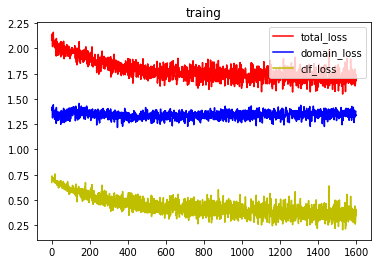

In [33]:
plt.plot(range(len(total_loss)),total_loss,c='r',label='total_loss')
plt.plot(d_loss,c='b',label='domain_loss')
plt.plot(c_loss,c='y',label='clf_loss')
plt.title('traing')
plt.legend(loc='best')
plt.show()

#res

max target accuracy:  77.8


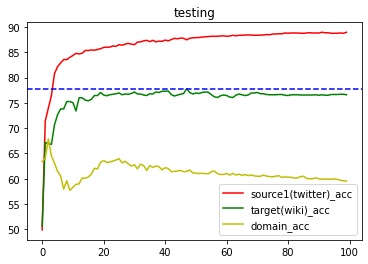

In [34]:
print('max target accuracy: ',max(acc_list3))
plt.plot(range(len(acc_list1)),acc_list1,c='r',label='source1(twitter)_acc')
# plt.plot(acc_list2,c='b',label='source2(forum)_acc')
plt.plot(acc_list3,c='g',label='target(wiki)_acc')
plt.plot(acc_list4,c='y',label='domain_acc')
plt.axhline(max(acc_list3),c='b',linestyle='--')
plt.title('testing')
plt.legend(loc='best')
plt.show()


1.   W->T: [51.45, 70.85, 76.95, 76.65, 76.80]

2.   T->W: [55.60, 72.25, 77.10, 77.35, 77.80]

